# Tech part

In [51]:
import warnings
warnings.filterwarnings("ignore")

import os
import sklearn
import librosa
import librosa.display

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List
from tqdm.auto import tqdm

# Данные

Данные хранятся в `./vox-test-audio`, мы имеем два голоса: **Oksana** и **Omazh**, попробуем послушать каждый из них:

In [4]:
path_example_oksana = './vox-test-audio/data/oksana/example_0.wav'
ipd.Audio(path_example_oksana)

In [6]:
path_example_omazh = './vox-test-audio/data/omazh/example_0.wav'
ipd.Audio(path_example_omazh)

Можно заметить, что они искажены. Узнаем, сможет ли нейронная модель отличить их.

# EDA

Для начала посмотрим на распределение длин аудиосигналов. Для этого воспользуемся библиотекой librosa, можно сказать, что она будет основная в этом проекте.

Для начала загрузим Аудиофайл с помощью `librosa.load`. 

Возвращает: аудиозапись в виде формы временного ряда и частоту дискретизации.

Частота дискретизации (sample rate) - это количество аудио семплов, передаваемых в секунду, которое измеряется в Гц или кГц. Можно проверить длину звука, разделив общее количество данных на частоту дискретизации.

![image](./img/audio_base/time.png)

In [42]:
y, sr = librosa.load('./vox-test-audio/data/oksana/example_0.wav')
print('y:', y)
print('y shape:', np.shape(y))
print('Sample Rate (KHz):', sr)
print('Len of Audio:', np.shape(y)[0]/sr)

y: [0. 0. 0. ... 0. 0. 0.]
y shape: (197524,)
Sample Rate (KHz): 22050
Len of Audio: 8.958004535147392


Этот фрагмент возвращает звуковой временной ряд в качестве массива numpy с частотой дискретизации по умолчанию 22 кГц моно. Это поведение можно изменить с помощью повторного семплинга на частоте 44,1 кГц.

`librosa.load(audio_data, sr=44100)`



Отлично, теперь посмотрим по каждому из класса:

In [262]:
def get_files(path_dir: str) -> List[str]:
    files = os.listdir(path_dir)
    files = [path_dir+file_name for file_name in files]
    return files

def get_len_files(files: List[str]) -> List[int]:
    lengths = []
    for file in tqdm(files, total=len(files)):
        if file[-9:] == '.DS_Store':
             continue
        y, sr = librosa.load(file)
        length = np.shape(y)[0]/sr
        lengths.append(length)
    return np.array(lengths)

In [263]:
oksana_files = get_files('./vox-test-audio/data/oksana/')
oksana_lens = get_len_files(oksana_files)
print(f'oksana min: {oksana_lens.min()}, oksana max: {oksana_lens.max()}, oksana mean: {oksana_lens.mean()}')

  0%|          | 0/91 [00:00<?, ?it/s]

oksana min: 4.078004535147392, oksana max: 13.508027210884354, oksana mean: 7.345904761904762


In [264]:
omazh_files = get_files('./vox-test-audio/data/omazh/')
omazh_lens = get_len_files(omazh_files)
print(f'omazh min: {omazh_lens.min()}, omazh max: {omazh_lens.max()}, omazh mean: {omazh_lens.mean()}')

  0%|          | 0/46 [00:00<?, ?it/s]

omazh min: 4.138004535147393, omazh max: 16.268027210884355, omazh mean: 9.358460065507687


# Time Domain Features

Чтобы оцифровать звуковую волну, мы должны преобразовать сигнал в ряд чисел, чтобы мы могли ввести его в наши модели. Это делается путем измерения амплитуды звука через фиксированные промежутки времени.

С помощью `librosa.display.waveplot` можно визуализировать аудиофайл

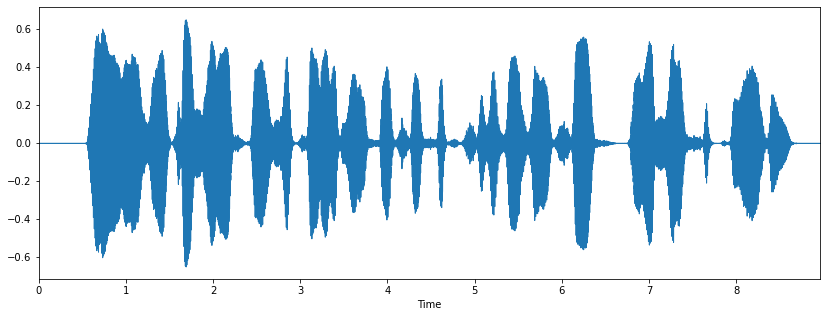

In [46]:
y, sr = librosa.load('./vox-test-audio/data/oksana/example_0.wav')

plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

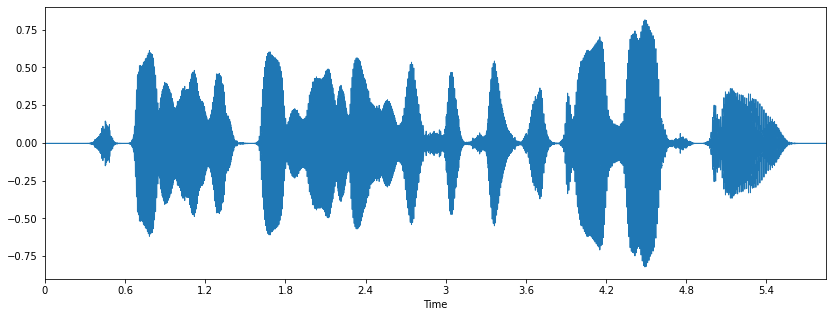

In [73]:
y, sr = librosa.load('./vox-test-audio/data/omazh/example_0.wav')

plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

Аудиоданные получают путем дискретизации звуковой волны через регулярные интервалы времени и измерения интенсивности или амплитуды волны на каждой выборке. Метаданные для этого аудио сообщают нам частоту дискретизации, которая представляет собой количество выборок в секунду.

В обработке аудиосигналов общей классикой принято использовать дргое представление звука, а именно спектограмму.

## Zero crossing rate (ZCR)

ZCR аудиосигнала определяется как скорость, с которой сигнал меняет знак. ZCR - это эффективный и простой способ определить, является ли речевой кадр голосовым, невокализованным или беззвучным. Ожидается, что невокализованные сегменты производят более высокие ZCR, чем для голосовых сегментов, в идеале ZCR равны нулю для сегментов молчания.

![image](./img/audio_base/zrc.png)

In [74]:
y, sr = librosa.load('./vox-test-audio/data/oksana/example_0.wav')

zrc = librosa.zero_crossings(y, pad=False)
print(sum(zrc))

12404


# Спектограмма

In [269]:
y, sr = librosa.load('./vox-test-audio/data/oksana/example_0.wav')

Для начала стоит обсудить, что такое спект. Спектр - это набор частот, которые объединяются для создания сигнала. Спектр отображает все частоты, которые присутствуют в сигнале, вместе с силой или амплитудой каждой частоты.
Самая низкая частота в сигнале называется основной частотой. Частоты, кратные основной частоте, называются гармониками.

Волновые формы, которые мы видели ранее, показывающие зависимость амплитуды от времени, являются одним из способов представления звукового сигнала. Спектр - это альтернативный способ представления одного и того же сигнала. Он показывает амплитуду в зависимости от частоты, и поскольку ось x показывает диапазон значений частоты сигнала, в данный момент времени мы просматриваем сигнал в частотной области.

![image](./img/audio_base/spectr.png)

**Спектрограмма**-это визуальное представление спектра частот сигнала, изменяющегося со временем. Спектрограмма сигнала отображает его спектр во времени и подобна «фотографии» сигнала. Он отображает время по оси x и частоту по оси y. Это как если бы мы снова и снова брали Спектр в разные моменты времени, а затем объединили их все вместе в единую картину. Он использует разные цвета для обозначения амплитуды или силы каждой частоты. Чем ярче цвет, тем выше энергия сигнала (дБ). Каждый вертикальный «срез» спектрограммы - это, по сути, спектр сигнала в данный момент времени и показывает, как мощность сигнала распределяется на каждой частоте, обнаруженной в сигнале в этот момент. Спектрограмма обычно изображается в виде тепловой карты, т. е. в виде изображения с интенсивностью, отображаемой изменением цвета или яркости.

Теперь посмотрим на спектрограмму, с помощью `sgram = librosa.stft(samples)` и `librosa.display.specshow(sgram)`:

`.stft` - преобразует данные с помощью **Оконного преобразование Фурье (The Short-time Fourier transform)**. 

STFT - это еще один вариант преобразования Фурье, который разбивает аудиосигнал на более мелкие части с помощью скользящего временного окна. Он выполняет **FFT** (быстрое преобзования Фурье) на каждом участке, а затем объединяет их. Таким образом, он может фиксировать изменения частоты во времени.

![image](./img/audio_base/stft.png)

Mel Spectrogram Hyperparameters:

1. `fmin` - минимальная частота
2. `fmax` - максимальная частота для отображения
3. `n_mels` - количество полос частот (например, ячейки Mel). Это высота спектрограммы.
4. `n_fft` - длина окна для каждого временного отрезка
5. `hot_length` - количество сэмплов, по которым сдвигается окно на каждом шаге. Следовательно, ширина спектрограммы = Общее количество выборок / длина_перехода

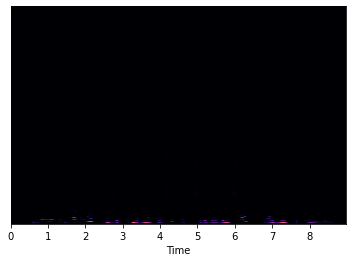

In [272]:
sgram = librosa.stft(y)
librosa.display.specshow(sgram, x_axis='time')

Вау эффекта не произошло. Что логично, я нарисовал простую спектограмму, а следовало бы спектограмму Мела, но в чем отличия? 

Например, большинство людей могут легко отличить звук от 100 Гц до 200 Гц. Однако по тому же принципу мы должны предположить, что можем определить разницу между 1000 и 1100 Гц, верно? Неа. И это надо учитывать и для этого была предложена **Шкала Мела**, это логарифмическое преобразование частоты сигнала.

Спектрограмма Мела использует шкалу Мела вместо частоты по y. Для обозначения цветов используется шкала децибел вместо амплитуды.

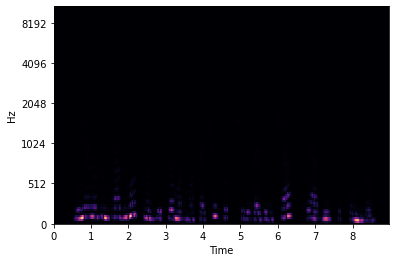

In [273]:
sgram = librosa.stft(y)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram, sr=sr)
librosa.display.specshow(mel_scale_sgram, x_axis='time', y_axis='mel')

Это лучше, чем раньше, но большая часть спектрограммы все еще темная и не содержит достаточно полезной информации. Итак, давайте изменим его, чтобы использовать шкалу децибел вместо амплитуды.

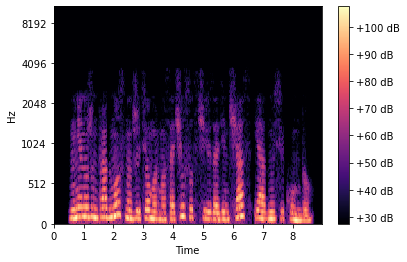

In [278]:
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

## MFCC

Спектрограммы Мела подходят для большинства приложений глубокого обучения аудио. Однако для проблем, связанных с человеческой речью, таких как автоматическое распознавание речи MFCC (Mel Frequency Cepstral Coefficients) иногда работает лучше. Еще MFCC могут довольно хорошо представлять тембр.

Основная процедура разработки MFCC следующая:

1. Преобразование из Герц в шкалу Мела
2. Возьмите логарифм представления звука Мела
3. Возьмите логарифмическую величину и используйте дискретное косинусное преобразование
4. Этот результат создает спектр по частотам Мела, а не по времени, тем самым создавая MFCC.

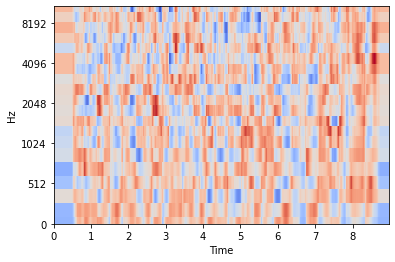

In [282]:
mfcc = librosa.feature.mfcc(y, sr=sr)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
librosa.display.specshow(mfcc, sr=sr, x_axis='time', y_axis='mel')

Попробуем сравнить MFCC Oksana и omazh

In [88]:
def show_mfcc(audio_path: str, axi) -> None:
    y, sr = librosa.load(audio_path)
    mfcc = librosa.feature.mfcc(y, sr=sr)
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    librosa.display.specshow(mfcc, sr=sr, ax=axi, x_axis='time', y_axis='mel')

Text(0.5, 1.0, 'omazh')

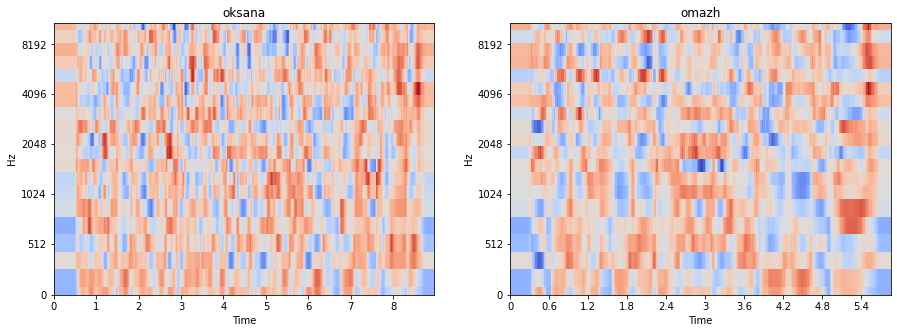

In [94]:
nrows, ncols, figsize = 1, 2, [15, 5]
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axi = ax.flat

show_mfcc('./vox-test-audio/data/oksana/example_0.wav', axi[0])
show_mfcc('./vox-test-audio/data/omazh/example_0.wav', axi[1])

axi[0].set_title('oksana')
axi[1].set_title('omazh')


In [283]:
def plot_mmfcs(same_samples: List[str], title: str = 'Oksana', n: int=10) -> None:    
    fig = plt.figure(figsize=(25,12))
    fig.suptitle(title, fontsize=30)
    for i in range(n):
        if same_samples[i][-9:] == '.DS_Store':
             continue
        plt.subplot(5,4,i+1)
        y, sr = librosa.load(same_samples[i], sr=16000)
        S = librosa.feature.melspectrogram(y, sr=sr)
        log_S = librosa.power_to_db(S)
        mfcc = librosa.feature.mfcc(S=log_S)
        mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
        librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
        plt.axis('off');

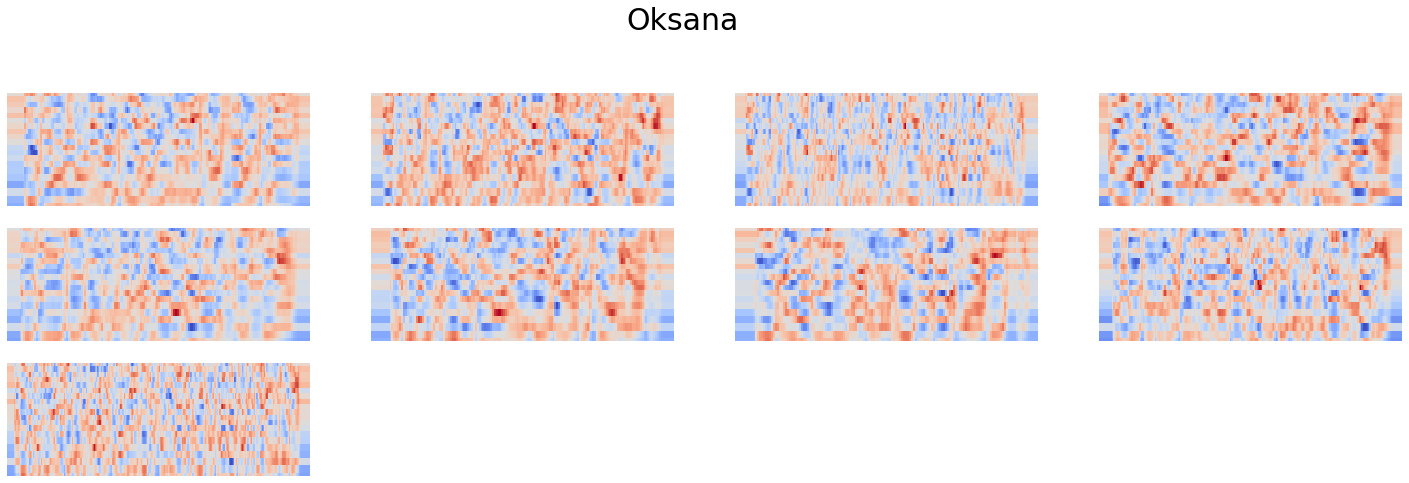

In [284]:
oksana_files = get_files('./vox-test-audio/data/oksana/')
plot_mmfcs(oksana_files, 'Oksana')

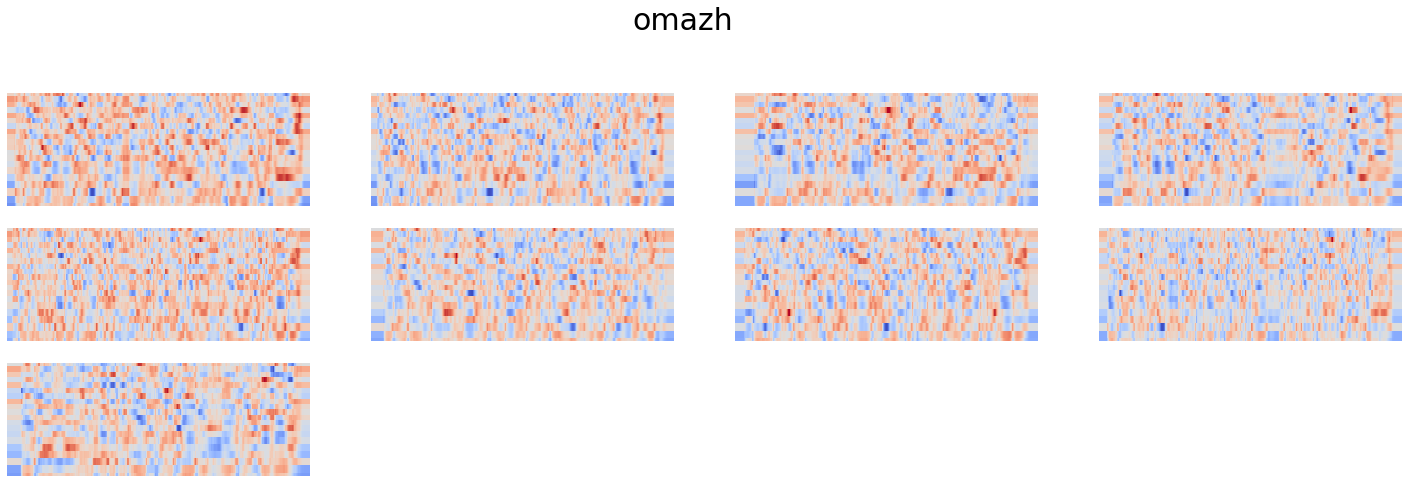

In [285]:
omazh_files = get_files('./vox-test-audio/data/omazh/')
plot_mmfcs(omazh_files, 'omazh')